In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf


import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, Conv2D,MaxPooling2D, Flatten, BatchNormalization
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
levels = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
path = "/content/gdrive/MyDrive/COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level + '/images')):
        data.append(['{}/images/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'result'])

data['path'] = path + '/' + data['image_file']

data.head()

,image_file,result,path
0,Normal/images/Normal-9154.png,Normal,/content/gdrive/MyDrive/COVID-19_Radiography_D...
1,Normal/images/Normal-9265.png,Normal,/content/gdrive/MyDrive/COVID-19_Radiography_D...
2,Normal/images/Normal-9002.png,Normal,/content/gdrive/MyDrive/COVID-19_Radiography_D...
3,Normal/images/Normal-94.png,Normal,/content/gdrive/MyDrive/COVID-19_Radiography_D...
4,Normal/images/Normal-9120.png,Normal,/content/gdrive/MyDrive/COVID-19_Radiography_D...


In [ ]:
print("Number of results: {}".format(data.shape[0]))

Number of results: 21173


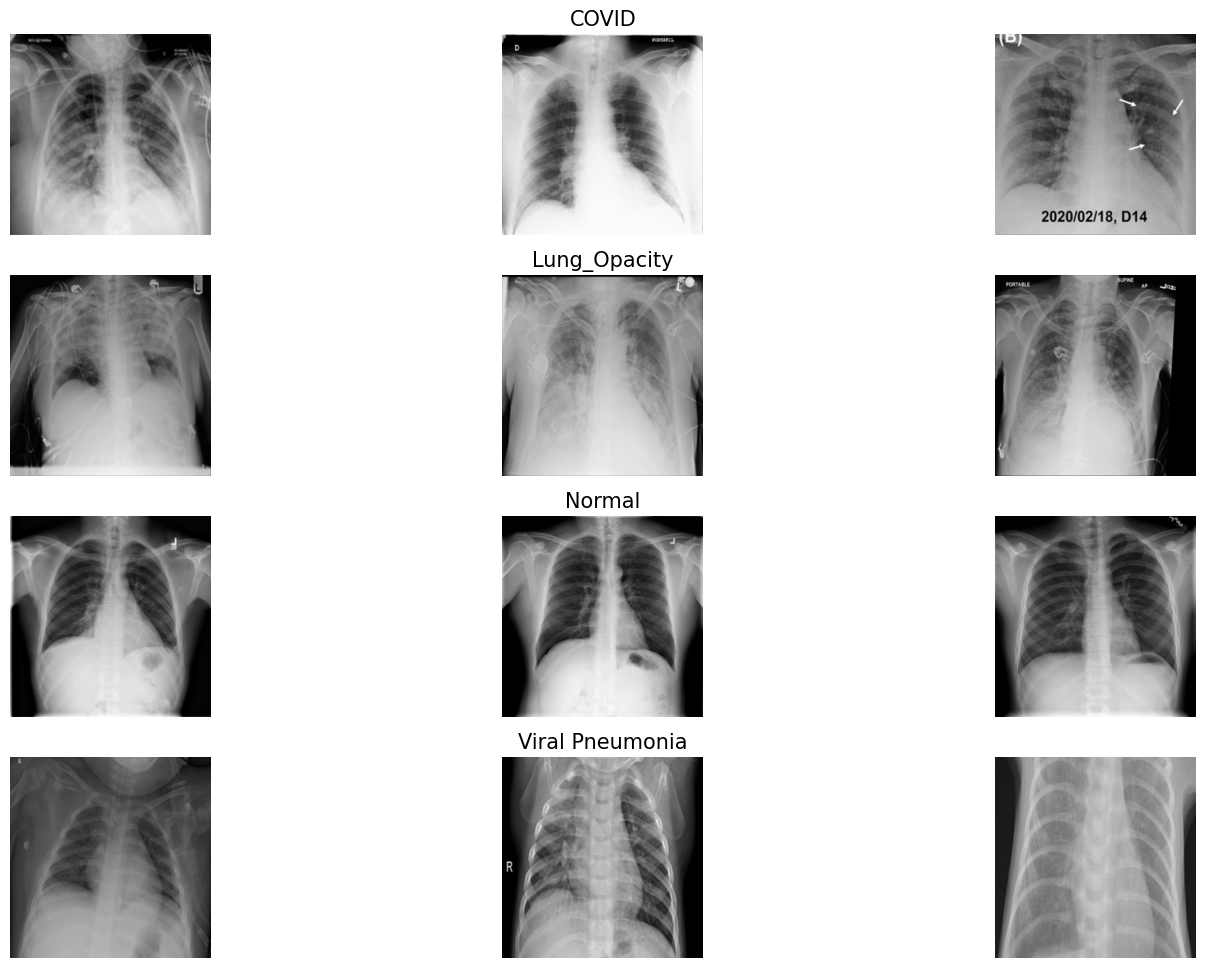

In [ ]:
n_samples = 3

fig, m_axs = plt.subplots(4, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['result']).groupby('result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

In [ ]:
print('Normal : ', list(data['result']).count('Normal'))
print('Covid : ', list(data['result']).count('COVID'))
print('Opacity : ', list(data['result']).count('Lung_Opacity'))
print('Pneumonia : ', list(data['result']).count('Viral Pneumonia'))

Normal :  10192
Covid :  3626
Opacity :  6012
Pneumonia :  1343


In [ ]:
pixel_img = []

for image in tqdm(data['path']):
    img=Image.open(image)
    img=ImageOps.grayscale(img)
    img=img.resize((64,64))
    img=np.asarray(img)
    img=img.reshape((64,64,1))
    pixel_img.append(img)

100%|██████████| 21173/21173 [55:25<00:00,  6.37it/s]


In [ ]:
pixel_img = np.array(pixel_img)
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity' : 2,
                               'Viral Pneumonia' : 3})

print(pixel_img.shape, label_img.shape)

(21173, 64, 64, 1) (21173,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img,
                                                    test_size=0.2, stratify=label_img)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(16938, 64, 64, 1)
(4235, 64, 64, 1)
(16938,)
(4235,)


In [ ]:
print("Train set: \n")
print(y_train.value_counts())
print("Test set: \n")
print(y_test.value_counts())

Train set: 

0    8153
2    4810
1    2901
3    1074
Name: result, dtype: int64
Test set: 

0    2039
2    1202
1     725
3     269
Name: result, dtype: int64


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

input_shape = (X_train.shape[1],X_train.shape[2],1)

In [ ]:
model1 = Sequential()
model1.add(Input(shape=input_shape))

model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding="valid"))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding="valid"))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', strides=(1,1), padding="valid"))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=(1,1), padding="valid"))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())
model1.add(Dense(256))
model1.add(Activation('relu'))

model1.add(Dropout(0.5))
model1.add(Dense(4))

model1.add(Activation('softmax'))
model1.summary()

model1.compile(loss='categorical_crossentropy', optimizer='rmsprop',
               metrics=['accuracy'])

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 64)       

In [ ]:

history2 = model1.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=128)


Epoch 1/50
120/120 [==============================] - 93s 766ms/step - loss: 1.0724 - accuracy: 0.5545 - val_loss: 1.1939 - val_accuracy: 0.3937
Epoch 2/50
120/120 [==============================] - 90s 747ms/step - loss: 0.8149 - accuracy: 0.6670 - val_loss: 0.8315 - val_accuracy: 0.6635
Epoch 3/50
120/120 [==============================] - 90s 749ms/step - loss: 0.6957 - accuracy: 0.7268 - val_loss: 1.0940 - val_accuracy: 0.4959
Epoch 4/50
120/120 [==============================] - 92s 769ms/step - loss: 0.6241 - accuracy: 0.7543 - val_loss: 0.6600 - val_accuracy: 0.7420
Epoch 5/50
120/120 [==============================] - 89s 746ms/step - loss: 0.5577 - accuracy: 0.7863 - val_loss: 0.9247 - val_accuracy: 0.5685
Epoch 6/50
120/120 [==============================] - 92s 766ms/step - loss: 0.5094 - accuracy: 0.8054 - val_loss: 0.5471 - val_accuracy: 0.7822
Epoch 7/50
120/120 [==============================] - 90s 750ms/step - loss: 0.4579 - accuracy: 0.8240 - val_loss: 0.4846 - val_ac

In [ ]:
loss1, acc1 = model1.evaluate(X_test, y_test, verbose=0)

print("Accuracy model1: %.2f%%" % (100.0 * acc1))


predictions = model1.predict(X_test)

Accuracy model1: 87.56%
133/133 [==============================] - 8s 58ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import seaborn as sns

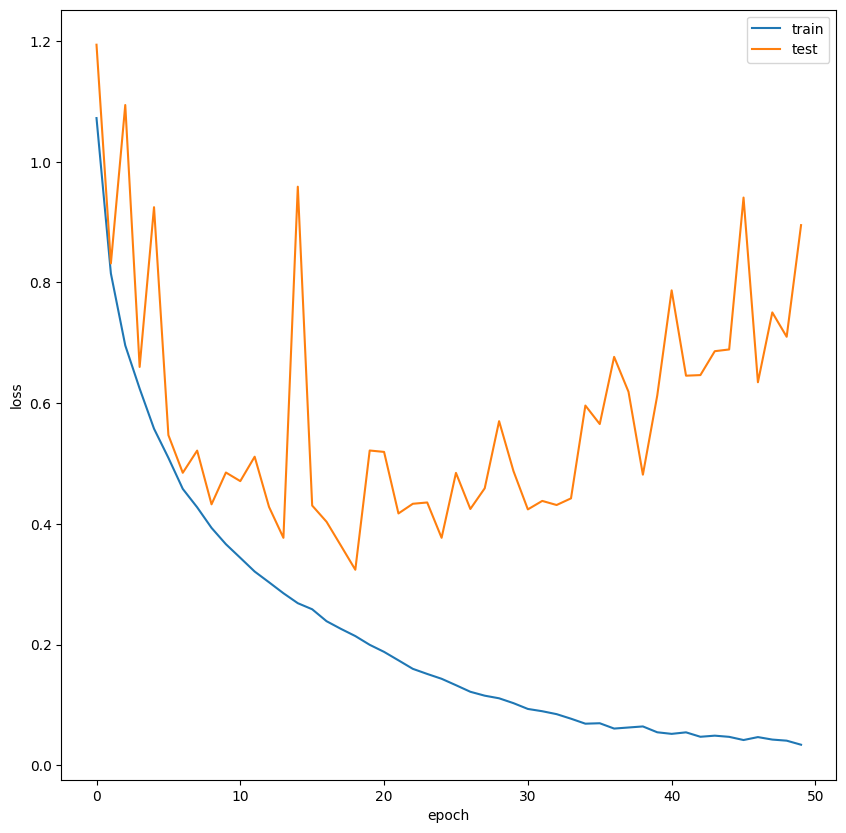

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.savefig('loss_function')
plt.show()

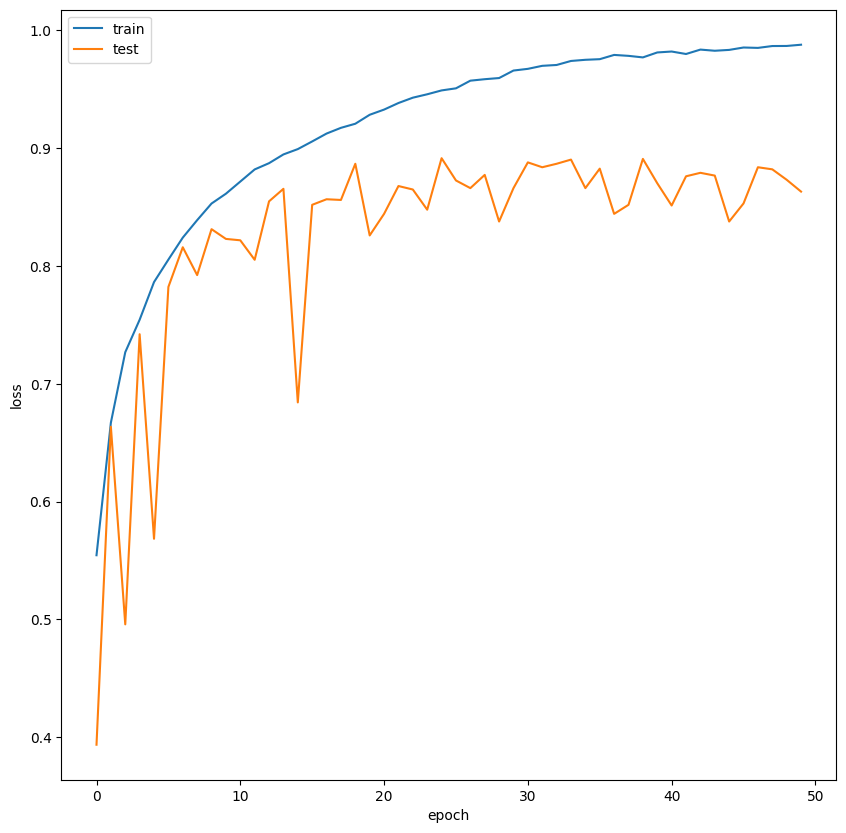

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.savefig('loss_function')
plt.show()

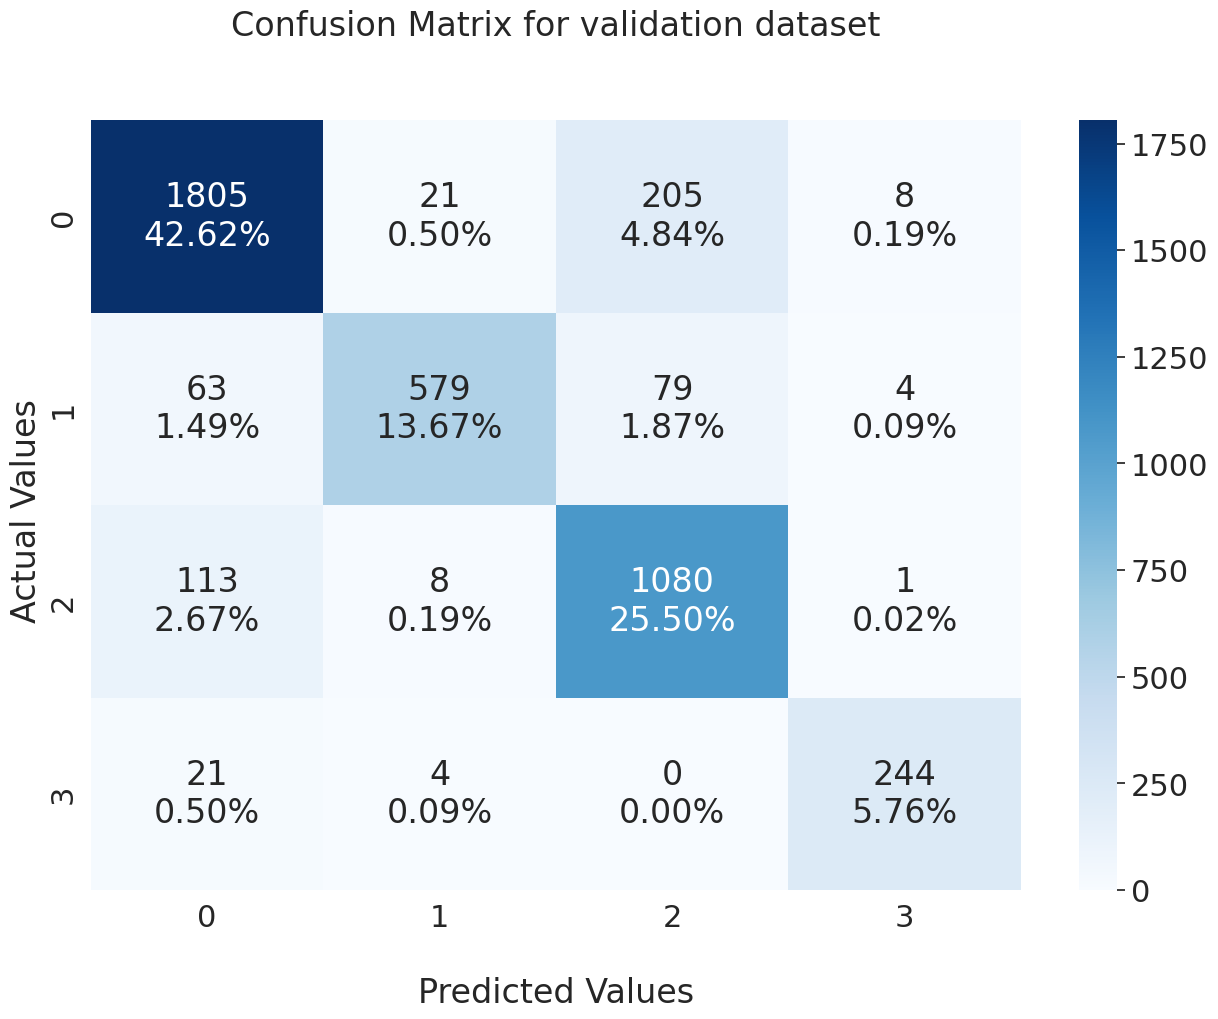

In [ ]:

plt.rcParams["figure.figsize"] = (15,10)
sns.set(font_scale=2.0)

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(4,4)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix for validation dataset\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');


#0 = normal
#1 = covid
#2 = opacity
#3 = pneumonia


In [ ]:
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=0.000005, min_delta=1e-4, mode='min')

In [ ]:
from tensorflow.keras import regularizers

model2 = Sequential()
model2.add(Input(shape=input_shape))

model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding="valid"))
model2.add(MaxPooling2D(pool_size=(2,2)))


model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding="valid"))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', strides=(1,1), padding="valid"))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=(1,1), padding="valid"))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(256, kernel_regularizer=regularizers.L1L2(0.001)))
model2.add(Activation('relu'))

model2.add(Dropout(0.5))
model2.add(Dense(4))

model2.add(Activation('softmax'))
model2.summary()

model2.compile(loss='categorical_crossentropy', optimizer='rmsprop',
               metrics=['accuracy'])

history2 = model2.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=128, callbacks=[reduce_lr_loss])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

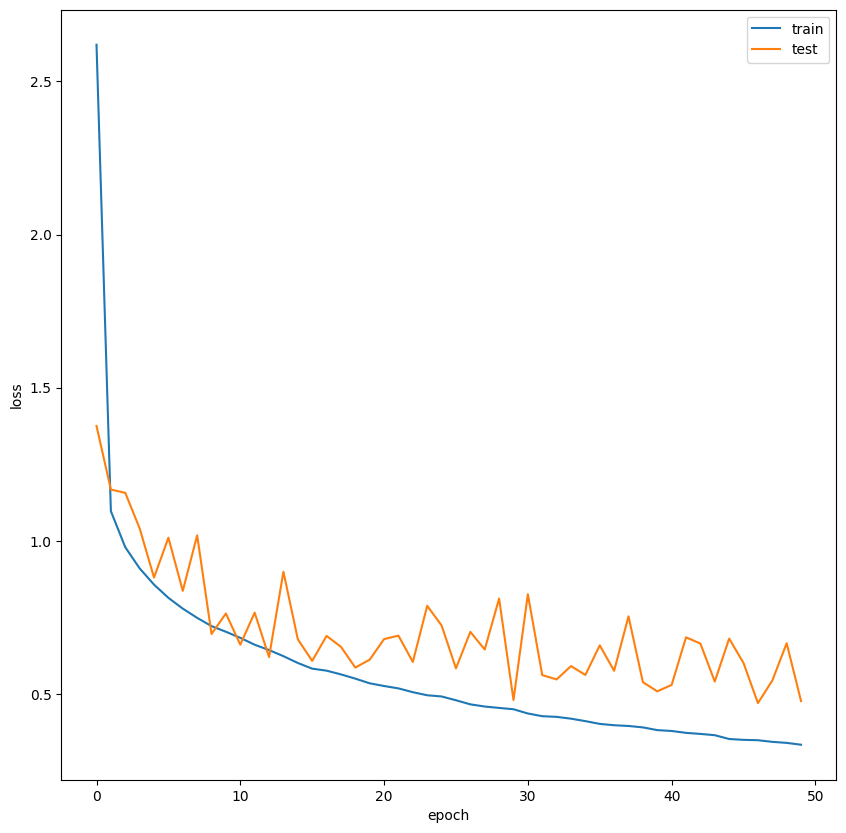

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.savefig('loss_function')
plt.show()

loss_1 = history2.history['loss']
val_loss_1 = history2.history['val_loss']

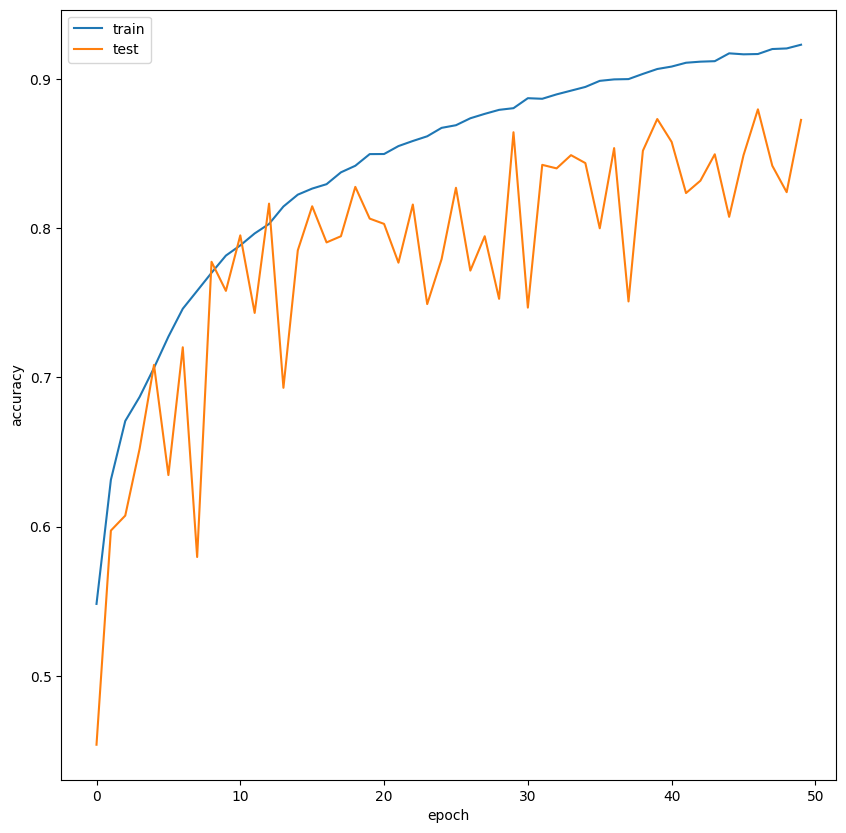

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.savefig('loss_function')
plt.show()

acc_1 = history2.history['accuracy']
val_acc_1 = history2.history['val_accuracy']

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )

datagen.fit(X_train)

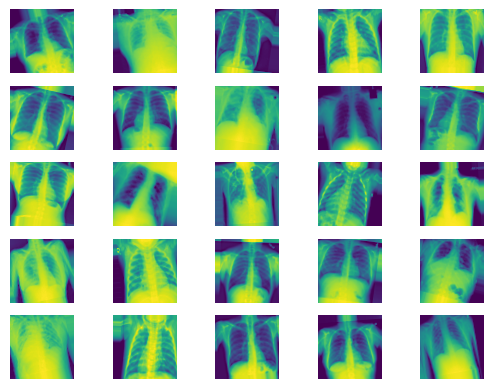

In [ ]:
#visualization of new images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=25):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(X_batch[i])
        plt.axis('off')
    plt.show()
    break

In [ ]:
#testing data augmentation on convolutional model 8
model2.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

start_time = time.time()
history3=model2.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                    steps_per_epoch = len(X_train)/128, epochs=50, validation_data=(X_test, y_test))
print("Calculation time:", time.time() - start_time)

Epoch 1/50


<ipython-input-31-2dca29a08bec>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3=model2.fit_generator(datagen.flow(X_train, y_train, batch_size=128),


132/132 [==============================] - 13s 88ms/step - loss: 0.7278 - accuracy: 0.7745 - val_loss: 0.6025 - val_accuracy: 0.8153
Epoch 2/50
132/132 [==============================] - 10s 73ms/step - loss: 0.6261 - accuracy: 0.8038 - val_loss: 0.5117 - val_accuracy: 0.8437
Epoch 3/50
132/132 [==============================] - 10s 76ms/step - loss: 0.6165 - accuracy: 0.8069 - val_loss: 0.4949 - val_accuracy: 0.8621
Epoch 4/50
132/132 [==============================] - 11s 81ms/step - loss: 0.5981 - accuracy: 0.8141 - val_loss: 0.5046 - val_accuracy: 0.8468
Epoch 5/50
132/132 [==============================] - 11s 82ms/step - loss: 0.5881 - accuracy: 0.8150 - val_loss: 0.5094 - val_accuracy: 0.8524
Epoch 6/50
132/132 [==============================] - 10s 74ms/step - loss: 0.5746 - accuracy: 0.8211 - val_loss: 0.4442 - val_accuracy: 0.8713
Epoch 7/50
132/132 [==============================] - 11s 81ms/step - loss: 0.5691 - accuracy: 0.8256 - val_loss: 0.4730 - val_accuracy: 0.8671
Epo

In [ ]:
acc_2 = history3.history['accuracy']
val_acc_2 = history3.history['val_accuracy']
loss_2 = history3.history['loss']
val_loss_2 = history3.history['val_loss']

In [ ]:
import matplotlib.pyplot as plt  # library for plotting math functions: https://matplotlib.org/stable/index.html

def PlotTwoAccuracyComparison(acc1, val_acc1, acc2, val_acc2, lab1 = 'Model 1', lab2 = 'Model 2'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    plt.figure(figsize=(25,5))
    epochs = range(len(acc1))
    plt.plot(epochs, acc1, 'bo', label='Training accuracy for ' + lab1)
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy for ' + lab1)
    plt.plot(epochs, acc2, 'ro', label='Training accuracy for ' + lab2)
    plt.plot(epochs, val_acc2, 'r', label='Validation accuracy for ' + lab2)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def PlotTwoLossComparison(loss1, val_loss1, loss2, val_loss2, lab1 = 'Model 1', lab2 = 'Model 2'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    plt.figure(figsize=(25,5))
    epochs = range(len(loss1))
    plt.plot(epochs, loss1, 'bo', label='Training loss for ' + lab1)
    plt.plot(epochs, val_loss1, 'b', label='Validation loss for ' + lab1)
    plt.plot(epochs, loss2, 'ro', label='Training loss for ' + lab2)
    plt.plot(epochs, val_loss2, 'r', label='Validation loss for ' + lab2)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

<Figure size 1000x1000 with 0 Axes>

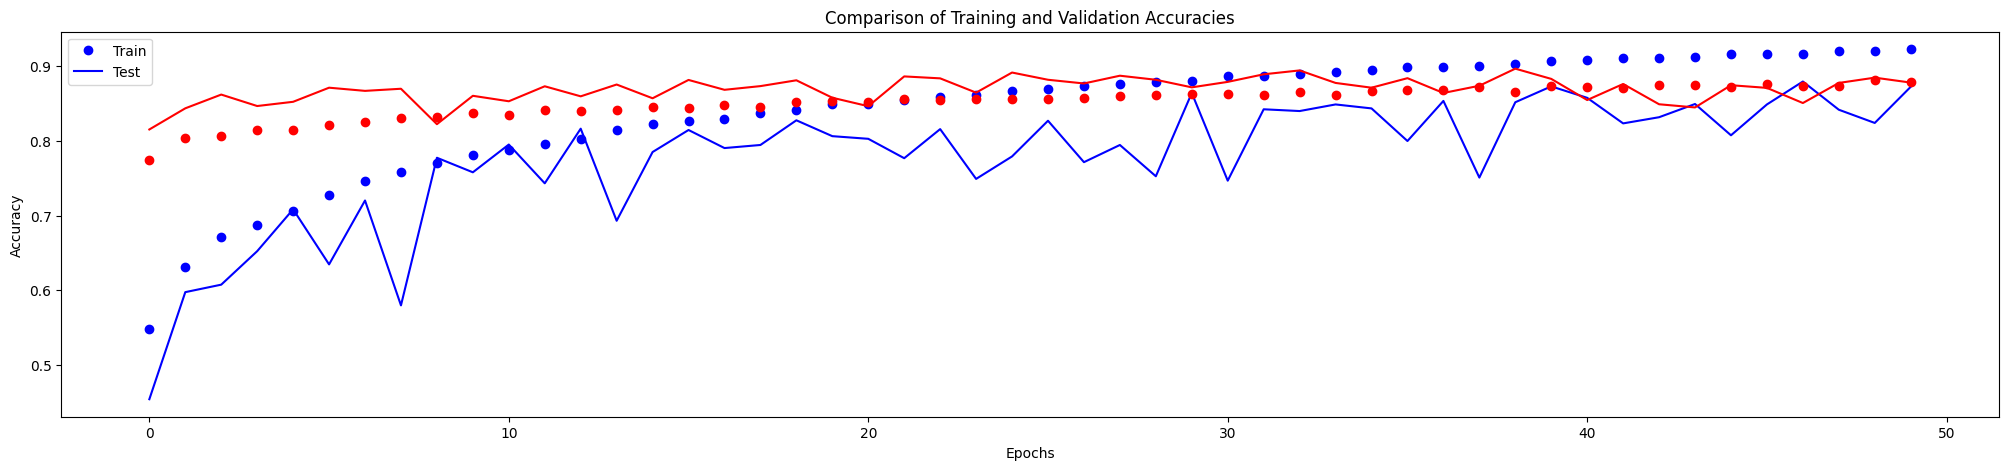

<Figure size 1000x1000 with 0 Axes>

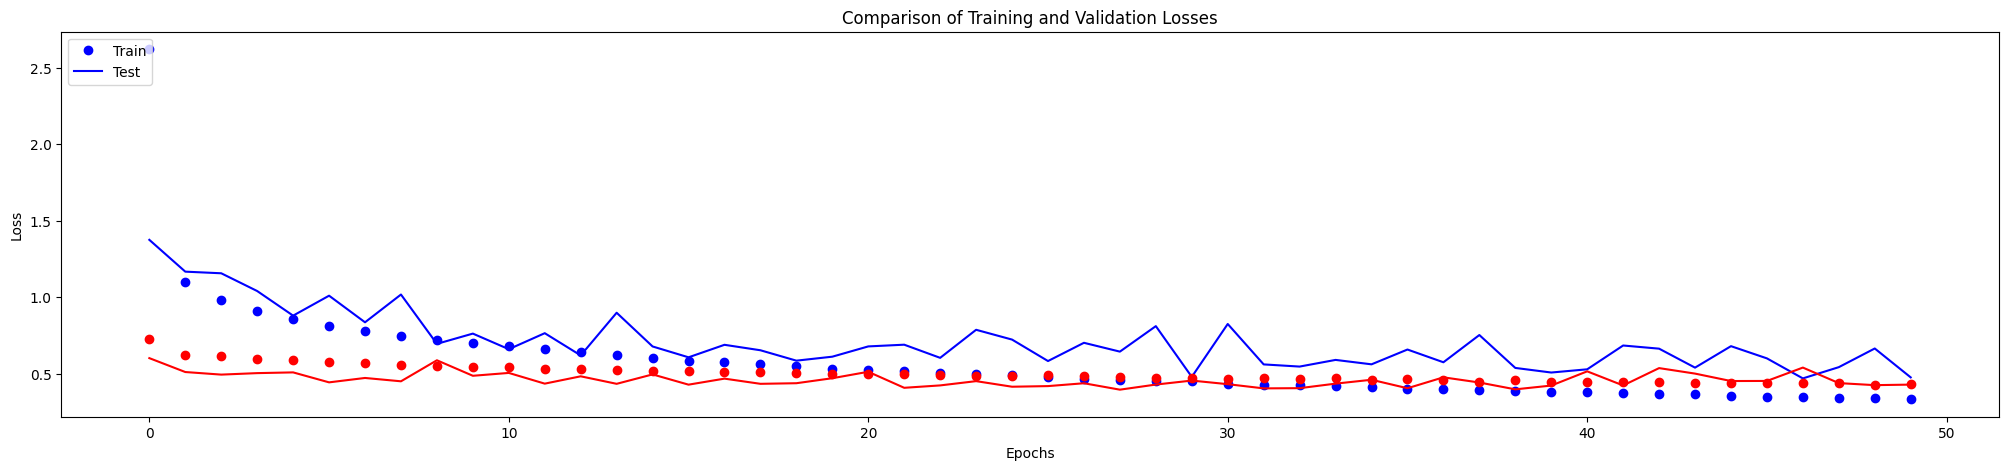

In [ ]:
PlotTwoAccuracyComparison(acc_1, val_acc_1, acc_2, val_acc_2, lab1 = 'Model 1', lab2 = 'Model 2')
PlotTwoLossComparison(loss_1, val_loss_1, loss_2, val_loss_2, lab1 = 'Model 1', lab2 = 'Model 2')

In [ ]:
#testing data augmentation on convolutional model 8
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

start_time = time.time()
history4=model2.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                    steps_per_epoch = len(X_train)/128, epochs=50, validation_data=(X_test, y_test))
print("Calculation time:", time.time() - start_time)

Epoch 1/50


<ipython-input-13-4d44f5b66a0d>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history4=model2.fit_generator(datagen.flow(X_train, y_train, batch_size=128),


132/132 [==============================] - 14s 82ms/step - loss: 0.6725 - accuracy: 0.7870 - val_loss: 0.5210 - val_accuracy: 0.8434
Epoch 2/50
132/132 [==============================] - 10s 78ms/step - loss: 0.5950 - accuracy: 0.8161 - val_loss: 0.4523 - val_accuracy: 0.8685
Epoch 3/50
132/132 [==============================] - 9s 71ms/step - loss: 0.5703 - accuracy: 0.8206 - val_loss: 0.4735 - val_accuracy: 0.8581
Epoch 4/50
132/132 [==============================] - 10s 72ms/step - loss: 0.5570 - accuracy: 0.8267 - val_loss: 0.4996 - val_accuracy: 0.8531
Epoch 5/50
132/132 [==============================] - 10s 78ms/step - loss: 0.5423 - accuracy: 0.8317 - val_loss: 0.4598 - val_accuracy: 0.8666
Epoch 6/50
132/132 [==============================] - 10s 78ms/step - loss: 0.5252 - accuracy: 0.8402 - val_loss: 0.4302 - val_accuracy: 0.8805
Epoch 7/50
132/132 [==============================] - 10s 76ms/step - loss: 0.5221 - accuracy: 0.8390 - val_loss: 0.4486 - val_accuracy: 0.8715
Epoc

In [ ]:
loss2, acc2 = model2.evaluate(X_test, y_test, verbose=0)

print("Accuracy model1: %.2f%%" % (100.0 * acc2))


predictions = model2.predict(X_test)

Accuracy model1: 89.14%
133/133 [==============================] - 0s 2ms/step


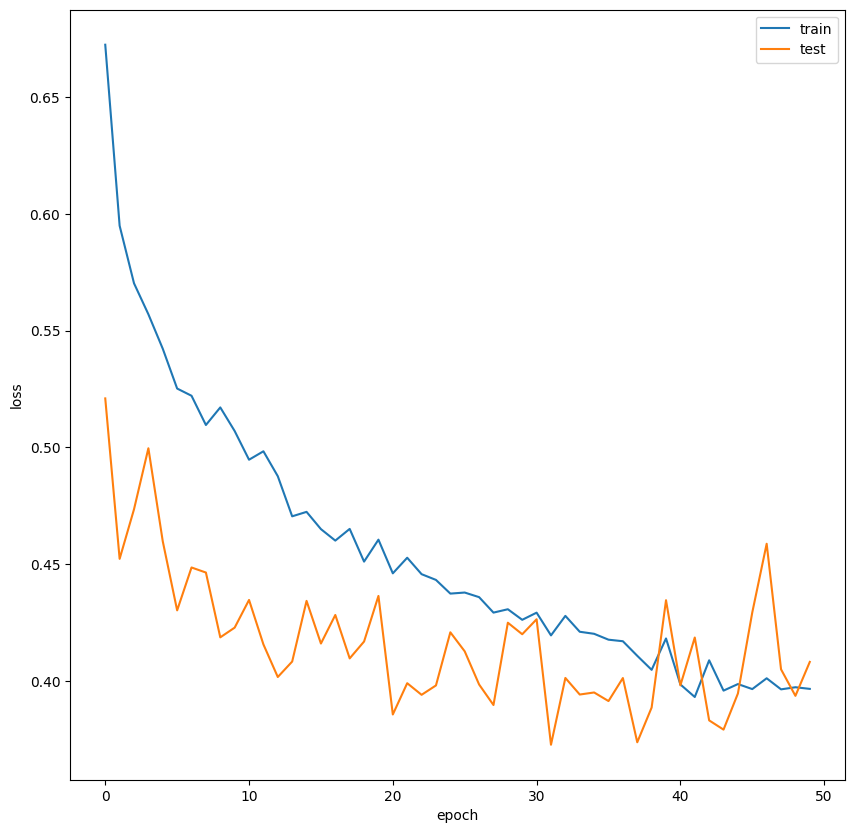

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.savefig('loss_function')
plt.show()

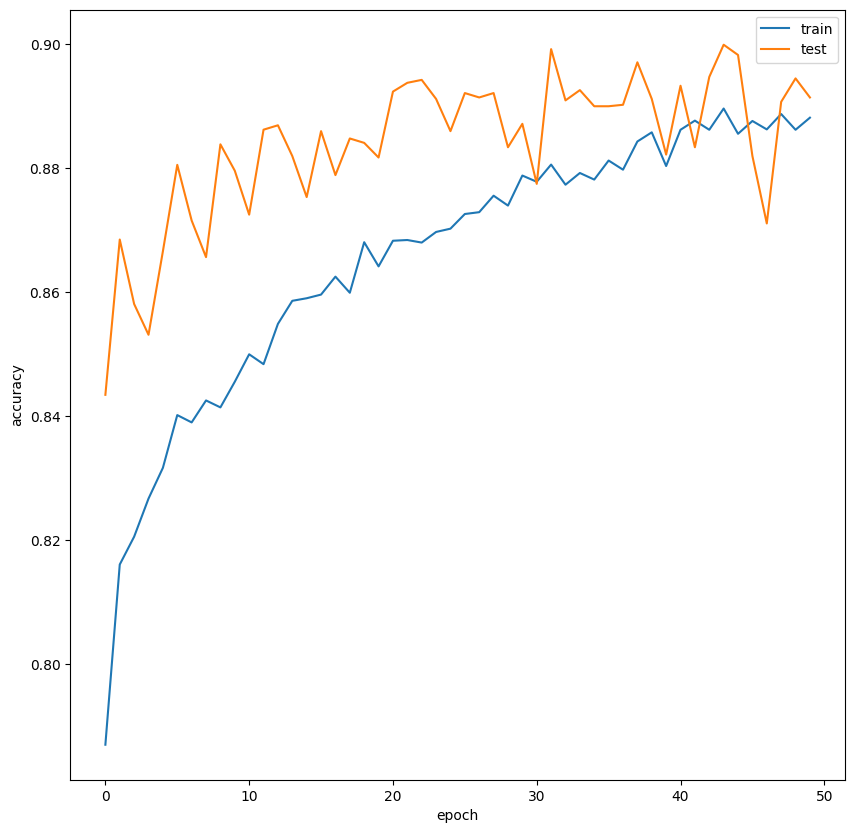

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.savefig('loss_function')
plt.show()


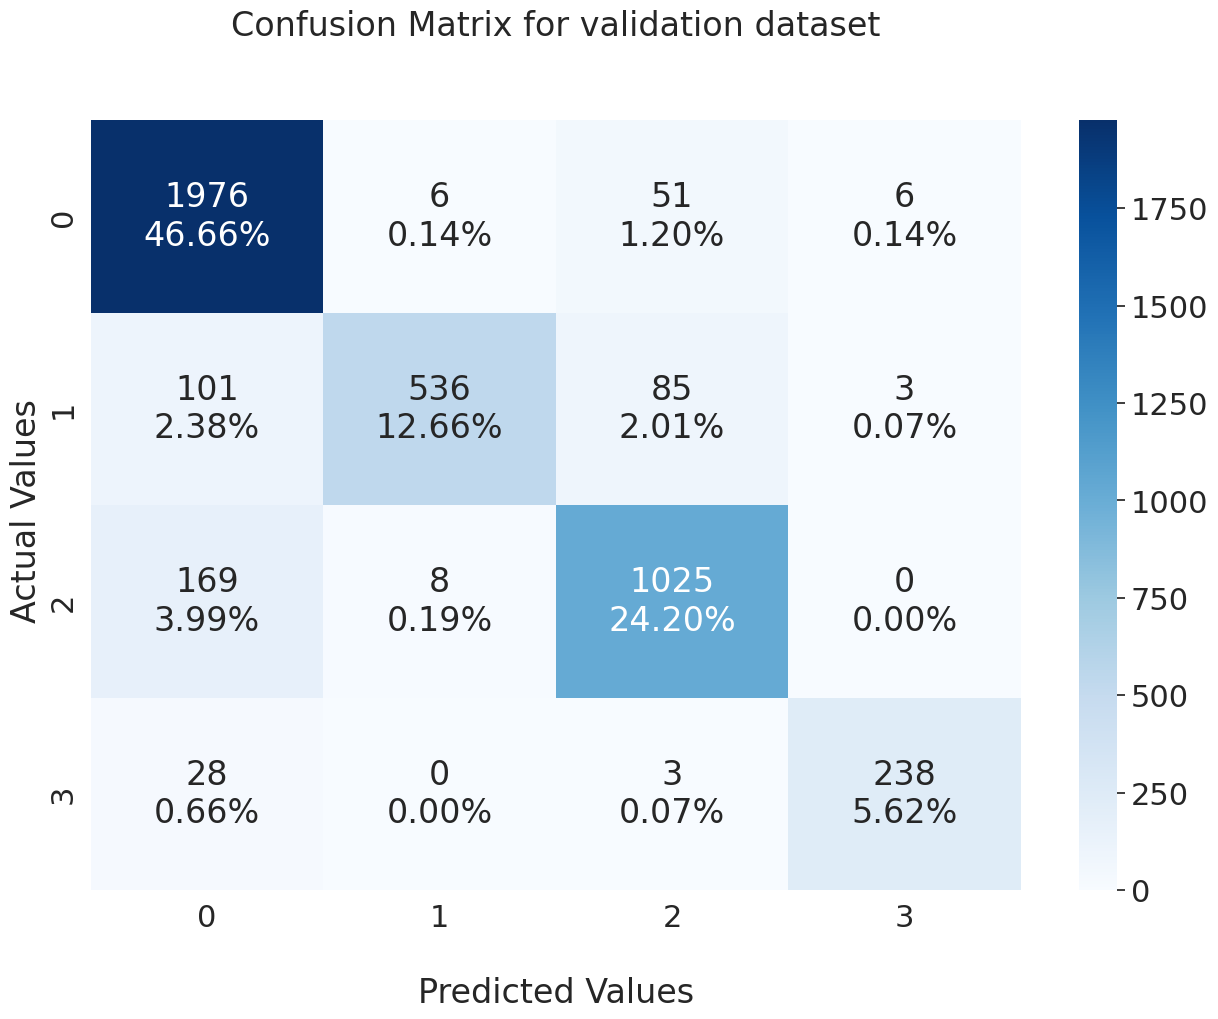

In [ ]:

plt.rcParams["figure.figsize"] = (15,10)
sns.set(font_scale=2.0)

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(4,4)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix for validation dataset\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');


#0 = normal
#1 = covid
#2 = opacity
#3 = pneumonia
